In [1119]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
titanic = pd.read_csv('./Titanic.csv')

# Display the first few rows of the dataframe
titanic.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Step 1

In [1120]:
def QuantileBinning(feature, bin_number):
    """
    This function takes a numerical feature and the number of bins, and
    returns the feature binned into quantile-based bins.

    Parameters:
    - feature (pandas.Series): The numerical feature to be binned.
    - bin_number (int): The number of quantile bins.

    Returns:
    - pandas.Series: A series of discrete features binned by quantile.
    """
    # Use qcut to create quantile-based bins for the feature
    # If there are fewer unique values than bins, qcut could throw an error.
    # 'duplicates' parameter handles this by dropping redundant bins.
    return pd.qcut(feature, q=bin_number, labels=False, duplicates='drop')

# One example
feature_test = pd.DataFrame(np.random.rand(100),  columns=['Column_A'])
feature_test_discrete = QuantileBinning(feature_test['Column_A'], 10)

def label_encoder(feature):
    unique_labels = pd.unique(feature)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    transformed_feature = np.array([label_to_int[label] for label in feature])
    return transformed_feature

In [1121]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
# Fill missing values in 'age' with the average age
titanic.fillna({'age': titanic['age'].mean()}, inplace=True)


# Discretization
titanic['age'] = QuantileBinning(titanic['age'], 10)

features = ['pclass', 'sex', 'age', 'sibsp']
target = 'survived'
encoder = ce.OrdinalEncoder(cols=features)
print(encoder)


# make sure feature and target are not null
print(titanic.isnull().sum())

# Split the data into 80% training and 20% test sets
X = titanic[features]
y = titanic[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)
train = encoder.fit_transform(titanic[['pclass', 'sex', 'age', 'sibsp', 'survived']])

OrdinalEncoder(cols=['pclass', 'sex', 'age', 'sibsp'])
Unnamed: 0       0
pclass           0
survived         0
name             0
sex              0
age              0
sibsp            0
parch            0
ticket           0
fare             1
cabin         1014
embarked         2
boat           823
body          1188
home.dest      564
dtype: int64


In [1122]:
X_train.head()

,pclass,sex,age,sibsp
464,1,1,1,1
888,2,1,2,1
475,1,2,3,2
326,1,1,4,1
655,2,1,1,2


In [1123]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1047, 4), (262, 4), (1047,), (262,))

In [1124]:
X_train.dtypes, X_test.dtypes, y_train.dtypes, y_test.dtypes

(pclass    int64
 sex       int64
 age       int64
 sibsp     int64
 dtype: object,
 pclass    int64
 sex       int64
 age       int64
 sibsp     int64
 dtype: object,
 dtype('int64'),
 dtype('int64'))

# Step 2

In [1125]:
# define your entropy function and information gain function
from math import log2


def entropy(y):
    """Calculate the entropy of the label distribution."""
    probs = y.value_counts(normalize=True)
    return -sum([p * log2(p) for p in probs if p > 0])


def information_gain(data, split_feature, target):
    """Calculate information gain of a feature."""
    total_entropy = entropy(data[target])
    values, counts = np.unique(data[split_feature], return_counts=True)

    weighted_entropy = 0
    for i, value in enumerate(values):
        subset = data[data[split_feature] == value]
        subset_entropy = entropy(subset[target])

        weight = counts[i] / len(data)
        weighted_entropy += weight * subset_entropy

    info_gains = total_entropy - weighted_entropy
    return info_gains


for feature in features:
    gain = information_gain(train, feature, target)
    
    print(f"Information Gain {feature}: {gain}")

Information Gain pclass: 0.0704074128460409
Information Gain sex: 0.2055048727200759
Information Gain age: 0.018607530828718133
Information Gain sibsp: 0.026983534163970146


So the first split should be "sex"

# Step 3

In [1126]:
from sklearn.tree import DecisionTreeClassifier

student_id = 20035085

# Instantiate the DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(
    criterion='gini', max_depth=3, random_state=student_id)

# Prepare the features and target variables for training
features = ['pclass', 'sex', 'age', 'sibsp']
target = 'survived'

# Fit the decision tree model
X = titanic[features]
y = titanic[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)


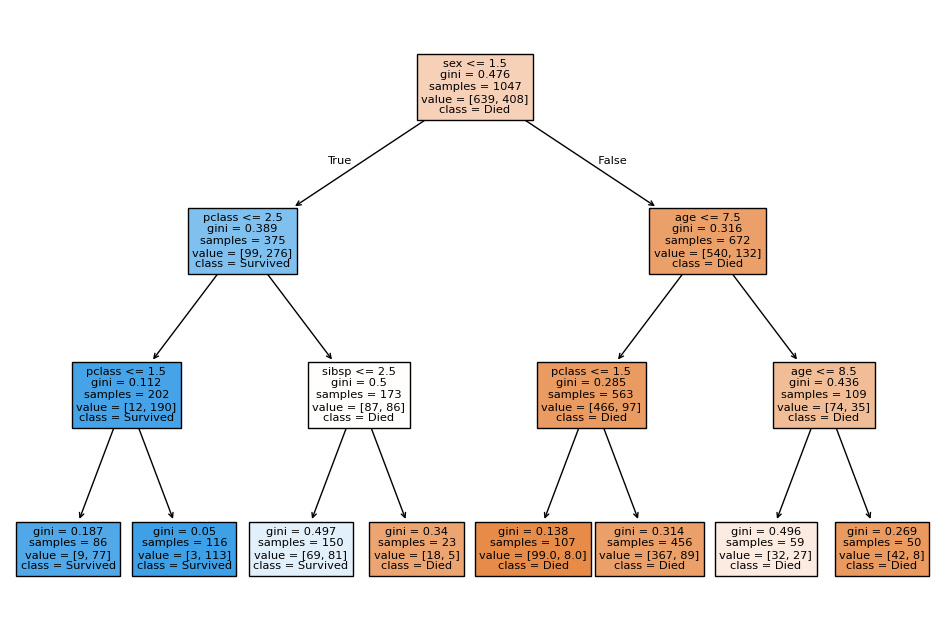

In [1127]:
# Plot the full decision tree
from sklearn import tree

plt.figure(figsize=(12, 8))

tree.plot_tree(clf_gini.fit(X_train, y_train), feature_names=features,
               class_names=["Died", "Survived"],  filled=True)
plt.show()

In [1128]:
# Define your performance metrics including accuracy, precision, recall and F1-scorre
from sklearn.metrics import accuracy_score

y_pred_gini = clf_gini.predict(X_test)
print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))


Model accuracy score with criterion gini index: 0.2176


In [1129]:
y_pred_train_gini = clf_gini.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))

Training-set accuracy score: 0.7918


# Step 4

In [660]:
from sklearn.model_selection import GridSearchCV

# Define a range of max_leaf_nodes values to search
param_grid = {'max_leaf_nodes': list(range(5, 20))}

# Run grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train) # Note testing set cannot be used

# Get the best estimator with the optimal max_leaf_nodes parameter


# Plot the pruned decision tree


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                            15, 16, 17, 18, 19]})

# Step 5


In [661]:
## it's an example (max_depth)

In [662]:
def ensemble_vote(models, X):

    # Perform majority vote
    # For each sample, count the votes for each class (0 or 1)

    # Determine the winning class for each sample: it's the one with the most votes
    # If there's a tie, we choose the class with the highest index (1 in this case)


    return ensemble_predictions

# Use the defined function to get predictions from the ensemble of the three trees
models = [best_tree, dt_max_depth, dt_opt_critia]
ensemble_predictions = ensemble_vote(models, X_test)

# Calculate performance metrics for the ensemble using the previously defined function


NameError: name 'best_tree' is not defined

In [ ]:
# Train a random forest model using the optimal tree you found in step 4 and compare the ensembled model with the random forest 